In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import duckdb
import tree
import os

import pymc as pm
import arviz as az
import itertools as it

pd.set_option('display.max_columns', None)
pd.set_option("display.precision",2)

In [2]:
import pytensor.tensor as pt

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
#path = '/content/gdrive/My Drive/Data/summary_revenue_data.csv'
path = '/content/gdrive/My Drive/Data/CHL_CHL_DATA_COLAB.csv'
df = pd.read_csv(path)
df.columns = df.columns.str.lower()
df.head()

,psu_combo_before,net_mrc_before
0,D,267.98
1,D,260.00
2,D,255.00
3,D,242.00
4,D,240.00


In [69]:
# Define the stratification column and the sampling fraction
strata_col = 'psu_combo_before'
sample_fraction = 0.05

# Perform stratified sampling
stratified_sample = df.groupby(strata_col).apply(lambda x: x.sample(frac=sample_fraction, random_state=36))
stratified_sample = stratified_sample.reset_index(drop=True)

stratified_sample.psu_combo_before.value_counts().reset_index()[:10]

/tmp/ipython-input-588731191.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = df.groupby(strata_col).apply(lambda x: x.sample(frac=sample_fraction, random_state=36))


,psu_combo_before,count
0,DH,6028
1,DVH,3830
2,D,2577
3,DVPH,1624
4,DV,1561
5,DVP,615
6,DPH,453
7,DVM,196
8,DP,191
9,DM,171


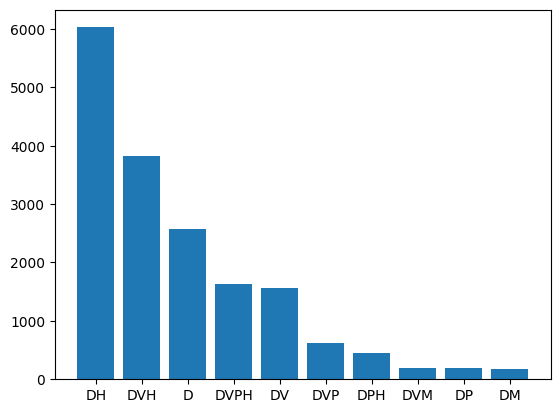

In [7]:
plt.bar(stratified_sample.psu_combo_before.value_counts().reset_index()[:10]['psu_combo_before'],
        stratified_sample.psu_combo_before.value_counts().reset_index()[:10]['count'])
plt.show()

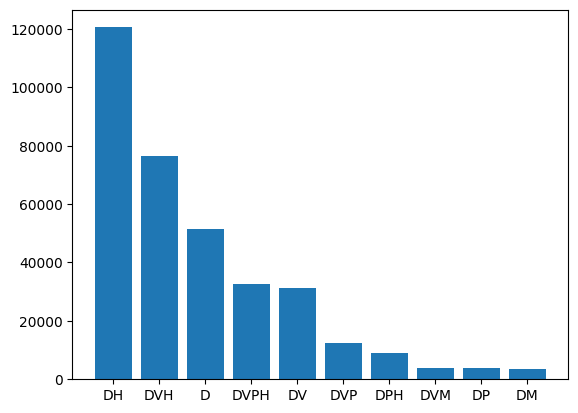

In [8]:
plt.bar(df.psu_combo_before.value_counts().reset_index()[:10]['psu_combo_before'],
        df.psu_combo_before.value_counts().reset_index()[:10]['count'])
plt.show()

# 1) Main effects

In [70]:
# Example data
strings = list(stratified_sample.psu_combo_before.unique())
y = list(stratified_sample.net_mrc_before)  # your observed values

In [10]:
y[:5]

[155.0, 70.0, 153.98, 50.0, 70.0]

In [11]:
len(y)

17582

In [71]:
letters = sorted(list(set(''.join(strings))))
X = np.array([[1 if l in s else 0 for l in letters] for s in stratified_sample.psu_combo_before])

In [13]:
letters

['D', 'H', 'M', 'P', 'V']

In [14]:
X.shape

(17582, 5)

In [15]:
X[15_000:15_005]

array([[1, 0, 1, 0, 1],
       [1, 0, 1, 0, 1],
       [1, 0, 1, 0, 1],
       [1, 0, 1, 0, 1],
       [1, 0, 1, 0, 1]])

In [16]:
stratified_sample.psu_combo_before.iloc[15_000:15_005]

,psu_combo_before
15000,DVM
15001,DVM
15002,DVM
15003,DVM
15004,DVM


In [72]:
with pm.Model() as model_base:
    # Priors for letter effects
    #theta = pm.Normal('theta', mu=0, sigma=100, shape=len(letters))
    theta = pm.Normal('theta', mu=100, sigma=50, shape=len(letters))
    sigma = pm.HalfNormal('sigma', 50)

    # Expected value
    mu = pm.math.dot(X, theta)

    # Likelihood
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)

    idata_base = pm.sample(1000, tune=1000, target_accept=0.9, idata_kwargs={'log_likelihood':True})

Output()

In [73]:
print([ (i, j) for i, j in enumerate(letters)])

[(0, 'D'), (1, 'H'), (2, 'M'), (3, 'P'), (4, 'V')]


In [74]:
pm.summary(idata_base, var_names=['theta'])[['mean','r_hat']].T

,theta[0],theta[1],theta[2],theta[3],theta[4]
mean,96.04,20.85,18.11,27.85,130.66
r_hat,1.00,1.00,1.00,1.00,1.00


In [21]:
#az.plot_posterior(idata_base, var_names=["theta"]);

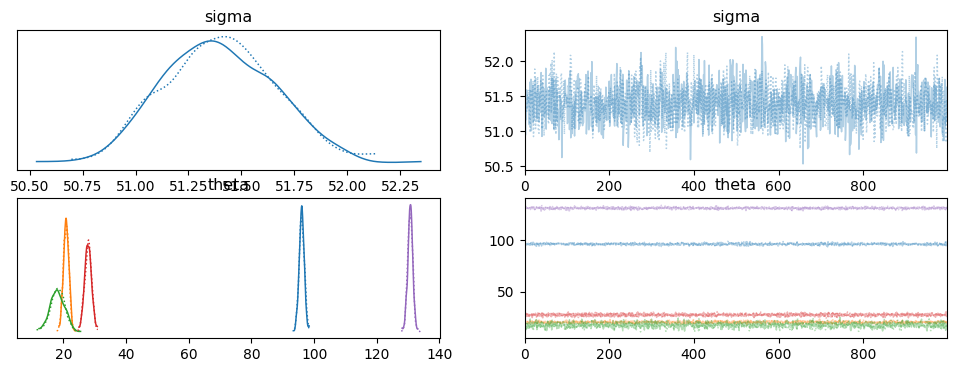

In [75]:
az.plot_trace(idata_base);

# 2) Main effects + Pairwise

In [168]:
# Define the stratification column and the sampling fraction
strata_col = 'psu_combo_before'
sample_fraction = 0.25

# Perform stratified sampling
stratified_sample = df.groupby(strata_col).apply(lambda x: x.sample(frac=sample_fraction))
stratified_sample = stratified_sample.reset_index(drop=True)

/tmp/ipython-input-2166656903.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = df.groupby(strata_col).apply(lambda x: x.sample(frac=sample_fraction))


In [169]:
# Example data (replace with yours)
strings = list(stratified_sample.psu_combo_before.unique())
y = list(stratified_sample.net_mrc_before)  # your observed values

In [170]:
# Build alphabet from data
letters = sorted(set(''.join(strings)))
print([ (i, j) for i, j in enumerate(letters)])

[(0, 'D'), (1, 'H'), (2, 'M'), (3, 'P'), (4, 'V')]


In [171]:
# Main-effects design (0/1 for presence of each letter)
X_main = np.array([[1 if l in s else 0 for l in letters] for s in stratified_sample.psu_combo_before])
main_names = letters[:]  # keep names
X_main[15_000:15_005]

array([[1, 1, 0, 0, 0],
       [1, 1, 0, 0, 0],
       [1, 1, 0, 0, 0],
       [1, 1, 0, 0, 0],
       [1, 1, 0, 0, 0]])

In [172]:
# Pairwise interactions: column = product of two main columns
pairs = list(it.combinations(range(len(letters)), 2))
pairs

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (1, 2),
 (1, 3),
 (1, 4),
 (2, 3),
 (2, 4),
 (3, 4)]

In [173]:
X_inter = np.array([
                    [X_main[i, j]*X_main[i, k]
                     for (j,k) in pairs]
                     for i in range(len(stratified_sample.psu_combo_before))
                    ])
inter_names = [f"{letters[j]}:{letters[k]}" for (j,k) in pairs]

print([ (i, j) for i, j in enumerate(inter_names)])

[(0, 'D:H'), (1, 'D:M'), (2, 'D:P'), (3, 'D:V'), (4, 'H:M'), (5, 'H:P'), (6, 'H:V'), (7, 'M:P'), (8, 'M:V'), (9, 'P:V')]


In [174]:
X_inter[15_000:15_005]

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [175]:
stratified_sample.psu_combo_before.iloc[15_000:15_005]

,psu_combo_before
15000,DH
15001,DH
15002,DH
15003,DH
15004,DH


In [176]:
# Final design and names
X = np.hstack([X_main, X_inter])  # [n_obs, n_params]
names = main_names + inter_names
print([ (i, j) for i, j in enumerate(names)])

[(0, 'D'), (1, 'H'), (2, 'M'), (3, 'P'), (4, 'V'), (5, 'D:H'), (6, 'D:M'), (7, 'D:P'), (8, 'D:V'), (9, 'H:M'), (10, 'H:P'), (11, 'H:V'), (12, 'M:P'), (13, 'M:V'), (14, 'P:V')]


In [177]:
X[15_000:15_005]

array([[1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [33]:
# i don't know why this is being done...
# Center y (omit intercept)
y_mean = np.mean(y)
y_c = y - y_mean
y_c[15_000:15_005]

array([ 24.78562962,  81.28562962,  79.78562962,  46.78562962,
       100.27562962])

In [34]:
y[15_000:15_005]

[198.5, 255.0, 253.5, 220.5, 273.99]

In [178]:
n_main = X_main.shape[1]
n_inter = X_inter.shape[1]
print(n_main)
print(n_inter)
print(round(y_mean,2))

5
10
173.71


In [85]:

with pm.Model() as model_hs:
    # Global noise
    sigma = pm.HalfNormal('sigma', 50)

    # ===== Main effects (weakly regularized Normal) =====
    theta_main = pm.Normal('theta_main', mu=100, sigma=50, shape=n_main)

    # ===== Interactions: Regularized Horseshoe =====
    # Global shrinkage
    tau = pm.HalfCauchy('tau', 1.0)
    # Local shrinkage per interaction
    lam = pm.HalfCauchy('lam', 1.0, shape=n_inter)
    # Slab to avoid over-shrinkage of truly large effects
    c2 = pm.InverseGamma('c2', alpha=2, beta=1)
    # Regularized horseshoe scale
    tau_tilde = tau * pt.sqrt(c2 / (c2 + (tau**2) * (lam**2)))
    theta_inter = pm.Normal('theta_inter', mu=-5.0, sigma=tau_tilde * lam, shape=n_inter)

    mu = pt.dot(X_main, theta_main) + pt.dot(X_inter, theta_inter)

    # Likelihood on centered y
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)

    idata_hs = pm.sample(1000, tune=1000, target_accept=0.99, chains=2, idata_kwargs={'log_likelihood':True})


Output()

ERROR:pymc.stats.convergence:There were 80 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [56]:
print([ (i, j) for i, j in enumerate(letters)])

[(0, 'D'), (1, 'H'), (2, 'M'), (3, 'P'), (4, 'V')]


In [86]:
pm.summary(idata_hs, var_names=['theta_main'])[['mean','r_hat']].T

,theta_main[0],theta_main[1],theta_main[2],theta_main[3],theta_main[4]
mean,95.49,21.34,24.08,25.09,129.81
r_hat,1.00,1.01,1.00,1.00,1.00


In [58]:
print([ (i, j) for i, j in enumerate(inter_names)])

[(0, 'D:H'), (1, 'D:M'), (2, 'D:P'), (3, 'D:V'), (4, 'H:M'), (5, 'H:P'), (6, 'H:V'), (7, 'M:P'), (8, 'M:V'), (9, 'P:V')]


In [87]:
pm.summary(idata_hs, var_names=['theta_inter'])[['mean','r_hat']].T

,theta_inter[0],theta_inter[1],theta_inter[2],theta_inter[3],theta_inter[4],theta_inter[5],theta_inter[6],theta_inter[7],theta_inter[8],theta_inter[9]
mean,-0.34,-0.07,-0.03,-0.31,-0.29,0.46,0.24,-0.12,-0.2,0.36
r_hat,1.00,1.01,1.01,1.00,1.00,1.00,1.01,1.00,1.0,1.01


Output()

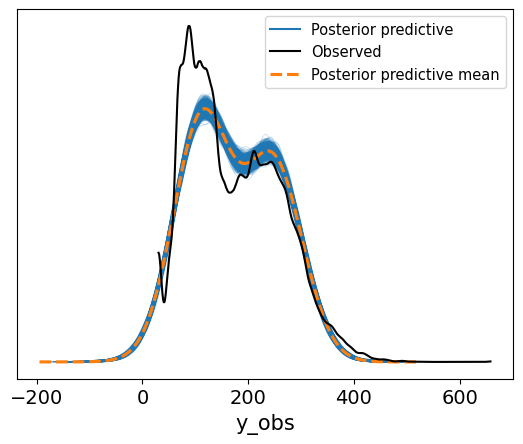

In [88]:
# In-sample posterior predictive
with model_hs:
    ppc_hs = pm.sample_posterior_predictive(idata_hs, var_names=['y_obs'])

az.plot_ppc(ppc_hs);  # visually check fit

In [179]:
with pm.Model() as model_lap:
    sigma = pm.HalfNormal('sigma', 50)

    theta_main = pm.Normal('theta_main', mu=100, sigma=50, shape=n_main)

    # Laplace prior (L1-like) for interactions
    # b is scale; smaller b => stronger shrinkage
    b = pm.HalfNormal('b', 10)
    theta_inter = pm.Laplace('theta_inter', mu=0.0, b=b, shape=n_inter)

    mu = pt.dot(X_main, theta_main) + pt.dot(X_inter, theta_inter)

    #y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y_c)
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)

    idata_lap = pm.sample(1000, tune=1000, target_accept=0.9, chains=2) # , idata_kwargs={'log_likelihood':True} use this to help compare the other models

Output()

ValueError: Not enough samples to build a trace.

In [64]:
print([ (i, j) for i, j in enumerate(letters)])

[(0, 'D'), (1, 'H'), (2, 'M'), (3, 'P'), (4, 'V')]


In [165]:
pm.summary(idata_lap, var_names=['theta_main'])[['mean','r_hat']].T

,theta_main[0],theta_main[1],theta_main[2],theta_main[3],theta_main[4]
mean,96.34,35.83,43.55,23.93,138.12
r_hat,1.00,1.00,1.00,1.01,1.00


In [66]:
print([ (i, j) for i, j in enumerate(inter_names)])

[(0, 'D:H'), (1, 'D:M'), (2, 'D:P'), (3, 'D:V'), (4, 'H:M'), (5, 'H:P'), (6, 'H:V'), (7, 'M:P'), (8, 'M:V'), (9, 'P:V')]


In [167]:
pm.summary(idata_lap, var_names=['theta_inter'])[['mean','r_hat']].T

,theta_inter[0],theta_inter[1],theta_inter[2],theta_inter[3],theta_inter[4],theta_inter[5],theta_inter[6],theta_inter[7],theta_inter[8],theta_inter[9]
mean,-15.81,-14.56,-2.89,-9.63,-7.15,3.38,1.01,-4.48,-5.1,3.28
r_hat,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.01


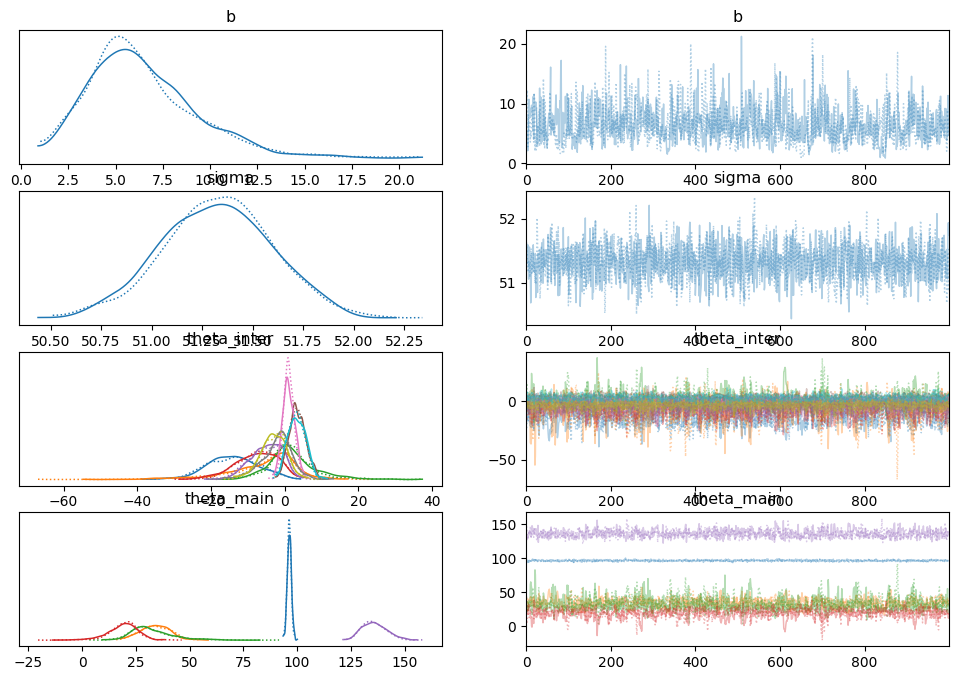

In [68]:
az.plot_trace(idata_lap);

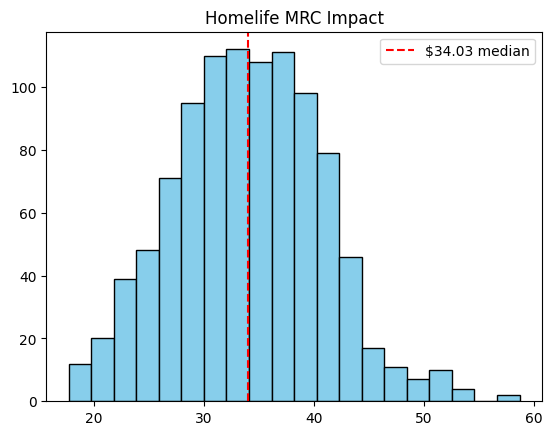

[(0, 'D'), (1, 'H'), (2, 'M'), (3, 'P'), (4, 'V')]


In [157]:
# i am grabbing thhe first 1000 draws with [0]
# i am then grabbing all the lists in the array with [:,]
# i am finally grabbing all the second values in all the lists with [:,1]
idata_lap.posterior.data_vars['theta_main'][0][:,1]

h_median = np.median(idata_lap.posterior.data_vars['theta_main'][0][:,1])
plt.axvline(h_median, color='r', linestyle='--', label=f'${h_median:.2f} median')
plt.hist(idata_lap.posterior.data_vars['theta_main'][0][:,1], bins=20, color='skyblue', edgecolor='black')
plt.legend()
plt.title('Homelife MRC Impact')
plt.show();

print([ (i, j) for i, j in enumerate(letters)])


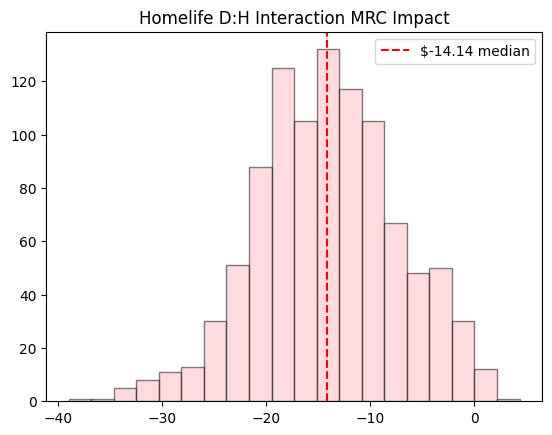

[(0, 'D:H'), (1, 'D:M'), (2, 'D:P'), (3, 'D:V'), (4, 'H:M'), (5, 'H:P'), (6, 'H:V'), (7, 'M:P'), (8, 'M:V'), (9, 'P:V')]


In [163]:

h_median = np.median(idata_lap.posterior.data_vars['theta_inter'][0][:,0])
plt.axvline(h_median, color='r', linestyle='--', label=f'${h_median:.2f} median')
plt.hist(idata_lap.posterior.data_vars['theta_inter'][0][:,0], bins=20, color='lightpink', alpha=0.5, edgecolor='black')
plt.legend()
plt.title('Homelife D:H Interaction MRC Impact')
plt.show();

print([ (i, j) for i, j in enumerate(inter_names)])

Output()

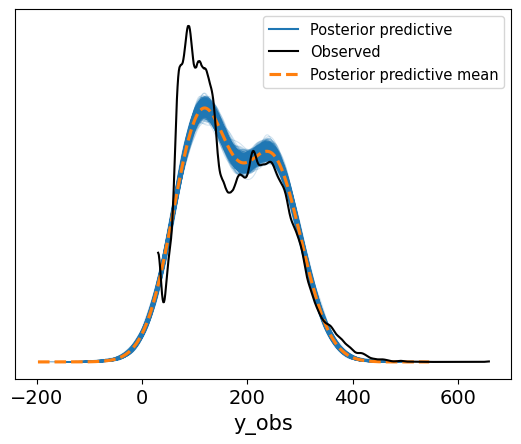

In [46]:
# In-sample posterior predictive
with model_lap:
    ppc_lap = pm.sample_posterior_predictive(idata_lap, var_names=['y_obs'])

az.plot_ppc(ppc_lap);  # visually check fit

In [89]:
# Compare HS vs Laplace with PSIS-LOO
cmp = az.compare({'base': idata_base, 'lap': idata_lap, 'hs': idata_hs}, method='BB-pseudo-BMA', ic='loo') # method=  'BB-pseudo-BMA'   'stacking'
print(cmp)

      rank  elpd_loo  p_loo  elpd_diff  weight      se     dse  warning scale
lap      0 -94195.21  14.20       0.00    0.56  133.20    0.00    False   log
hs       1 -94202.36   8.40       7.15    0.02  133.42    3.25    False   log
base     2 -94215.20   7.34      19.99    0.42  132.78  181.33    False   log


# 3) Extract “H” and its interactions

In [105]:
# Index helpers
letter_to_idx = {L: i for i, L in enumerate(letters)}
pair_to_idx = {name: i for i, name in enumerate(inter_names)}

def summarize_H(idata):
    # Posterior arrays
    th_main = idata.posterior['theta_main'].stack(draws=("chain","draw")).values
    th_inter = idata.posterior['theta_inter'].stack(draws=("chain","draw")).values

    # Main effect for E
    e_main = th_main[letter_to_idx['H'], :]

    # Pairwise interactions involving E
    e_pairs = []
    for L in letters:
        if L == 'H':
            continue
        p1 = f"{min(L,'H')}:{max(L,'H')}"  # ensure name matches inter_names format
        if p1 in pair_to_idx:
            e_pairs.append(th_inter[pair_to_idx[p1], :])
    e_pairs = np.array(e_pairs) if e_pairs else np.zeros((0, th_inter.shape[1]))

    return e_main, e_pairs


def hdi(x, cred=0.95):
    lo, hi = az.hdi(x, hdi_prob=cred)
    return float(lo), float(hi)


#e_main_hs, e_pairs_hs = summarize_H(idata_base)
#e_main_hs, e_pairs_hs = summarize_H(idata_hs)
e_main_hs, e_pairs_hs = summarize_H(idata_lap)


In [106]:
print("H (main):")
print("mean:  ", round(e_main_hs.mean(),2), "\nhdi95:", np.round(hdi(e_main_hs),2) )

H (main):
mean:   34.07 
hdi95: [20.39 45.98]


In [107]:
if e_pairs_hs.size:
    e_pairs_sum = e_pairs_hs.sum(axis=0)  # total H-related pairwise adjustment if all partners are present
    print("Sum of H pairwise interactions:")
    print("mean: ", round(e_pairs_sum.mean(),2), "\nhdi95:", np.round(hdi(e_pairs_sum),2))

Sum of H pairwise interactions:
mean:  -14.59 
hdi95: [-30.84   2.47]


# 6) Getting a clean “H” estimate

In [102]:
# Usage-weighted H interaction adjustment
from collections import Counter

co_counts = Counter()
for s in strings:
    if 'H' in s:
        for L in set(s):
            if L != 'H':
                co_counts[f"{min(L,'H')}:{max(L,'H')}"] += 1

total = sum(co_counts.values())
weights = {p: c/total for p, c in co_counts.items()} if total>0 else {}

def weighted_H_adjustment(idata):
    th_inter = idata.posterior['theta_inter'].stack(draws=("chain","draw")).values
    adj = 0.0
    for p, w in weights.items():
        if p in pair_to_idx:
            adj += w * th_inter[pair_to_idx[p], :]
    return adj

In [103]:
w_adj = weighted_H_adjustment(idata_lap)
print(f"H standalone (baseline):\t\t",         round(e_main_hs.mean(),2),           "hdi95:", np.round(hdi(e_main_hs),2))
print(f"H usage-weighted interaction adj.:\t", round(w_adj.mean(),2),               "hdi95:", np.round(hdi(w_adj),2))
print(f"H typical total:\t\t\t",               round((e_main_hs + w_adj).mean(),2), "hdi95:", np.round(hdi(e_main_hs + w_adj),2))

H standalone (baseline):		 34.07 hdi95: [20.39 45.98]
H usage-weighted interaction adj.:	 -4.4 hdi95: [-8.84  0.66]
H typical total:			 29.66 hdi95: [20.62 38.02]
